In [1]:
!pip3 install deepface
!pip3 install pillow
!pip3 install mediapipe

In [2]:
DATA_DIR = './.data'

In [16]:
from urllib.request import urlretrieve
import os
import utils
from zipfile import ZipFile

WFACE_DIR = DATA_DIR+'/wider_face'
WFACE_ANNOTATIONS_DIR = WFACE_DIR+'/annotations'
WFACE_IMAGES_DIR = WFACE_DIR+'/images'

os.makedirs(WFACE_DIR, exist_ok = True)

WFACE_VAL_A_PATH = WFACE_ANNOTATIONS_DIR+'/wider_face_split/wider_face_val_bbx_gt.txt'
WFACE_VAL_PATH = WFACE_IMAGES_DIR+'/WIDER_val/images'

wider_face_val_an_url = 'http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip'
file_path = WFACE_DIR+'/wider_face_split.zip'

if not os.path.exists(file_path):
    zip_file, _  = urlretrieve(wider_face_val_an_url, file_path)
    
    zf = ZipFile(zip_file)
    zf.extractall(WFACE_ANNOTATIONS_DIR) 
    zf.close()

wider_face_val_url = 'https://drive.google.com/file/d/1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q/view?usp=sharing'
file_path = WFACE_DIR+'/WIDER_val.zip'
if not os.path.exists(file_path):
    utils.download_file_from_google_drive('1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q', file_path)
    
    zf = ZipFile(file_path)
    zf.extractall(WFACE_IMAGES_DIR) 
    zf.close()

In [31]:
import re
import pandas as pd

wface_an_file = open(WFACE_VAL_A_PATH, "r")

blur_code = ['clear', 'normal blur', 'heavy blur']
expression_code = ['typical', 'exaggerate']
illumination_code = ['normal', 'extreme']
occlusion_code = ['none', 'partial', 'heavy']
pose_code = ['typical', 'atypical']
invalid = ['false', 'true']

#blur, expression, illumination, invalid, occlusion, pose
wface_val_df = pd.DataFrame(columns=[
    'img_path', 'group', 'face',
    'x', 'y', 'w', 'h', 'blur',
    'expression', 'illumination', 
    'invalid', 'occlusion',
    'pose'
])

i = 0
lines = wface_an_file.readlines()
while i < len(lines):
    m = re.search('[^--]+\.jpg$', lines[i])
    if m:
        img_path = lines[i].strip()
        group = img_path.split('/')[0]
    
        i += 1
        n_faces = int(lines[i])
        
        i += 1
        j = 0
        while i < len(lines) and not re.search('[^--]+\.jpg$', lines[i]):
            tokens = re.split('\s+', lines[i])
            tokens = filter(lambda x: len(x) > 0, tokens)
            tokens = [int(t) for t in tokens]
            values = [img_path, group, j]
            values.extend(tokens)
            wface_val_df.loc[len(wface_val_df)] = values
            i += 1
            j += 1
        
        if n_faces != j:
            print(img_path, ": faces({}, {}) didn't match".format(n_faces, j))
    else:
        print(lines[i], "not expected!")
        i += 1
            
wface_an_file.close()
wface_val_df.head()

,img_path,group,face,x,y,w,h,blur,expression,illumination,invalid,occlusion,pose
0,0--Parade/0_Parade_marchingband_1_465.jpg,0--Parade,0,345,211,4,4,2,0,0,0,2,0
1,0--Parade/0_Parade_marchingband_1_465.jpg,0--Parade,1,331,126,3,3,0,0,0,1,0,0
2,0--Parade/0_Parade_marchingband_1_465.jpg,0--Parade,2,250,126,3,4,2,0,0,0,2,0
3,0--Parade/0_Parade_marchingband_1_465.jpg,0--Parade,3,221,128,4,5,0,0,0,1,0,0
4,0--Parade/0_Parade_marchingband_1_465.jpg,0--Parade,4,427,116,3,4,2,0,0,0,2,0


In [32]:
import random

MAX_VARIATIONS = 14
visited_vars = {
    'blur': set(),
    'expression': set(),
    'illumination': set(),
    'invalid': set(),
    'occlusion': set(),
    'pose': set(),
}
visited_images = set()
visited_groups = set()
n_visited_vars = 0

vars = [
    'blur', 'expression', 'illumination', 
    'invalid', 'occlusion', 'pose'
]
def check_var(d, var):
    return d[var] not in visited_vars[var]

def add_var(d, var):
    if check_var(d, var):
        visited_vars[var].add(d[var])
        return 1
    return 0

varied_images = []
#blur, expression, illumination, invalid, occlusion, pose
while n_visited_vars < MAX_VARIATIONS:
    i = random.randint(0, len(wface_val_df)-1)
    d = wface_val_df.iloc[i]
    
    if d['img_path'] in visited_images:
        continue
    
    if d['group'] in visited_groups:
        continue
    
    checks = [check_var(d, var) for var in vars]
    if True in checks:
        varied_images.append(WFACE_VAL_PATH+'/'+d['img_path'])
        visited_images.add(d['img_path'])
        visited_groups.add(d['group'])
        for var in vars:
            n_visited_vars += add_var(d, var)

In [33]:
varied_images = [
    WFACE_VAL_PATH+'/11--Meeting/11_Meeting_Meeting_11_Meeting_Meeting_11_507.jpg',
    WFACE_VAL_PATH+'/2--Demonstration/2_Demonstration_Demonstration_Or_Protest_2_120.jpg',
    WFACE_VAL_PATH+'/14--Traffic/14_Traffic_Traffic_14_170.jpg',
    WFACE_VAL_PATH+'/28--Sports_Fan/28_Sports_Fan_Sports_Fan_28_590.jpg',
    WFACE_VAL_PATH+'/3--Riot/3_Riot_Riot_3_710.jpg',
    WFACE_VAL_PATH+'/51--Dresses/51_Dresses_wearingdress_51_741.jpg',
    WFACE_VAL_PATH+'/12--Group/12_Group_Group_12_Group_Group_12_935.jpg',
    WFACE_VAL_PATH+'/39--Ice_Skating/39_Ice_Skating_iceskiing_39_349.jpg',
    WFACE_VAL_PATH+'/37--Soccer/37_Soccer_soccer_ball_37_512.jpg'
 ]

<Figure size 2000x2000 with 0 Axes>

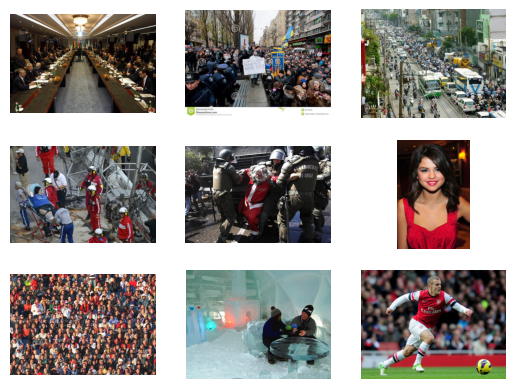

In [36]:
from PIL import Image
from matplotlib import pyplot as plt


VARIED_FACES_DIR = './.data/varied-images'
img_paths = varied_images

imgs = [Image.open(img_path, "r") for img_path in img_paths]
n_imgs = len(imgs)

plt.figure(figsize=(20, 20))

cols = 3
rows = n_imgs//cols
rows += 0 if n_imgs%cols == 0 else 1
f, axarr = plt.subplots(rows,cols) 
for i, img in enumerate(imgs):
  axarr[i//cols][i%cols].imshow(img)
  axarr[i//cols][i%cols].axis('off')

plt.show(block=True)

In [37]:
from deepface import DeepFace

backends = [
  'opencv', 
  'ssd', 
  'dlib', 
  'mtcnn', 
  'retinaface', 
  'mediapipe',
  'yolov8',
  'yunet',
  'fastmtcnn',
]

imgs_faces = []
for img_path in img_paths:
  face_objs = DeepFace.extract_faces(img_path = img_path, 
          target_size = (224, 224), 
          detector_backend = 'retinaface'
  )
  imgs_faces.append(face_objs)

2023-10-22 21:41:50.000489: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Directory  /Users/n0c09jf /.deepface created
Directory  /Users/n0c09jf /.deepface/weights created
retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /Users/n0c09jf/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:02<00:00, 51.5MB/s] 


In [ ]:
from PIL import Image
from PIL import ImageDraw

def annotate_image(img: Image, facial_areas, color='red'):
    dimg = ImageDraw.Draw(img)
    for box in facial_areas:
        dimg.rectangle(
            (box['x'], box['y'], box['x']+box['w'], box['y']+box['h']), 
            outline=color, width=3)

def annotate_images(imgs, imgs_faces):
  for i, img in enumerate(imgs):
    # face_obj: ['facial_area'], face_objs[0]['confidence'])
    facial_areas = [f['facial_area'] for f in imgs_faces[i]]
    annotate_image(img, facial_areas)


annotate_images(imgs, imgs_faces)


for i, img in enumerate(imgs):
  plt.imshow(img)
  plt.show(block=True)